# TP04 : Arbres de décision et Forêts aléatoires


## I. Implémentation

Il existe plusieurs implémentations des arbres de décision :
- ID3 (Iterative Dichotomiser 3): dévelopé en 1986 par Ross Quinlan. Il peut être appliqué seulement sur les caractéristiques nominales. Il est utilisé pour le classement.
- C4.5: une extension de ID3 par Ross Quinlan. Il peut être appliqué sur tous les types de caractéristiques. Il est utilisé pour le classement.
- C5.0: une extension commerciale de C4.5, toujours par Ross Quinlan.
- CART (Classification and Regression Trees): comme C4.5 mais utilise d'autres métriques. Aussi, l'algorithme supporte la régression.

Dans ce TP, on va implémenter ID3 pour les caracéristiques nominales et CART (classement) pour les caracéristiques numériques seulement .

### I.1. ID3

Ici, on va implémenter l'algorithme vu dans le cours. On va utiliser le dataset "jouer (nominales)" 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline

jouer = pd.read_csv("datasets/jouer.csv")

X_jouer = jouer.iloc[:, :-1].values # Premières colonnes 
Y_jouer = jouer.iloc[:,-1].values # Dernière colonne 

# Afficher le dataset "jouer"
jouer.head()

,temps,temperature,humidite,vent,jouer
0,ensoleile,chaude,haute,non,non
1,ensoleile,chaude,haute,oui,non
2,nuageux,chaude,haute,non,oui
3,pluvieux,douce,haute,non,oui
4,pluvieux,fraiche,normale,non,oui


#### I.1.1. Probabilité 

Etant donné une liste des valeurs $S$, la probabilité d'occurence d'une valeur $v$  est le nombre d'occurence de $v$ dans $S$ divisé par le nombre total des éléments de $S$. 

$$p(v/S) = \frac{|\{x / x \in S \text{ et } x = v\}|}{|S|}$$

Exemple, prenons la colonne "jouer". 
Le nombre de "oui" est 9 et le nombre total est 14. 
$$p(jouer=oui) = \frac{9}{14} = 0.6428571428571429$$

In [2]:
# TODO calculer la probabilité d'occurence d'une valeur val dans un ensemble S
# PS: si la division retourne toujours 0, essayer d'appliquer float(x) sur le numérateur ou le dénominateur
def P(S, v): 
    nbtotals=len(S) # recupérer |S|
    l=list(S) # on convertir vers une liste pour pouvoir utiliser count
    occ=l.count(v)
    return occ/nbtotals

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (0.6428571428571429,
#  0.35714285714285715,
#  0.2857142857142857,
#  0.35714285714285715)
#---------------------------------------------------------------------

P(Y_jouer, "oui"), P(X_jouer[:,0], "ensoleile"), P(X_jouer[:, 0], "nuageux"), P(X_jouer[:,0], "pluvieux")

(0.6428571428571429,
 0.35714285714285715,
 0.2857142857142857,
 0.35714285714285715)

#### I.1.2. Incertitude d'un ensemble

L'entropie de Shannon correspond à la quantité d'information contenue dans une source d'information ; plus la source émet d'informations différentes, plus l'entropie (ou l'incertitude sur ce que la source émet) est grande.
Donc, un ensemble avec une entropie de 0 contient les mêmes valeurs.
Etant donné : 
- $S$ une liste des valeurs 
- $V$ un ensemble de valeurs uniques de $S$ (vocabulaire) 

L'entropie de $S$ est calculée comme suit : 
$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$

Par exemple, la colonne "jouer" contient deux valeurs "oui" et "non". 
Son entopie est :
$$H(jouer) = - \frac{9}{14} * \log_2(\frac{9}{14}) - \frac{5}{14} * \log_2(\frac{5}{14}) = 0.9402859586706309$$ 


In [3]:
# TODO compléter la fonction d'entropie
# np.log2 : calcule log2 d'une valeur, vecteur ou matrice
def H(S):  
    V = np.unique(S)
   
    entropie = 0
    # Compléter ici
    for i in range(len(V)):
        v=V[i]
        p=P(S,v)
        a=-(p)*(np.log2(p))
        entropie=entropie+a
    return entropie 

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.9402859586706311, 1.5774062828523454)
#---------------------------------------------------------------------

H(Y_jouer), H(X_jouer[:,0])

(0.9402859586706311, 1.5774062828523454)

#### I.1.3. Division d'un ensemble

**Rien à programmer ici**

Ici, on essaye de diviser la liste des prédictions (classes) selon les valeurs d'un attribut (caractéristique, colonne) à des sous listes. 

Etant donné : 
- **Y** : la liste à diviser
- **A** : la liste des valeurs d'un attribut (caractéristique, colonne). C'est un vecteur aligné avec Y ; c-à-d, chaque élément de A a un élément de Y respectif.
- **v** : la valeur sur laquelle on divie.

$$S_{A,v} = \{y^{(i)} \in Y / a^{(i)} \in A \wedge a^{(i)} = v\}\}$$

Par exemple, si 
- $Y$ est la liste des prédictions de "jouer"
- $A$ est la liste des valeurs de la caractéristique "temps"
- $v$ est la valeur "ensoleile"
La sous ensemble de "jouer" où (temps = "ensoleile") contient 3 non et 2 oui 

In [4]:
def diviser_ID3(Y, A, v):
    msk = A == v
    return Y[msk]

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : array(['non', 'non', 'non', 'oui', 'oui'], dtype=object)
#---------------------------------------------------------------------

diviser_ID3(Y_jouer, X_jouer[:,0], "ensoleile")

array(['non', 'non', 'non', 'oui', 'oui'], dtype=object)

#### I.1.4. Gain d'entropie

Le gain d'entropie (information gain) est la différence entre l'entropie avant et après la division d'une liste $Y$ selon l'attribut $A$. 
En d'autres termes, combien d'incertitude dans $Y$ a été réduite après sa division en utilisant l'attribut $A$.

Etant donné : 
- **Y** : une liste à diviser
- **A** : une liste des valeurs d'un attribut (caractéristique, colonne) 
- **V** : l'ensemble des valeurs différentes de l'attribut A (vocabulaire)
- **p(v/A)** : la probabité d'occurence de la valeur $v$ dans $A$
- $Y_{A, v}$ : sous-ensemble de $Y$ où les valeurs de $V$ égalent à $v$  en utilisant la fonction précédente (diviser_ID3)

Le gain d'entrepie se calcule comme suit : 

$$IG(Y, A) = H(Y) - \sum_{v \in V} p(v/A) H(Y_{A, v})$$

In [5]:
# TODO Compléter la fonction du gain d'entropie
# elle doit rendre le gain d'entropie et l'entropie 
# On rend l'entropie pour ne pas recalculer ultérierement 
def IG(Y, A):
    V = np.unique(A)
    entropie = H(Y)
    ig_global = entropie
    somme=0
    # Compléter ici
    for i in range(len(V)):
        Yav=diviser_ID3(Y, A, V[i])
        somme=somme+(P(A,V[i])*H(Yav))
    ig_global=ig_global-somme
    return ig_global, entropie

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

IG(Y_jouer, X_jouer[:, 0])

(0.24674981977443933, 0.9402859586706311)

#### I.1.5. Choix de l'attribut de division ID3

Ici, vous devez chercher l'attribut qui maximise IG.

$$jj = \arg\max_j IG(Y, X_j)$$

La fonction doit rendre jj, le IG de division en utilisant jj et l'entropy

In [37]:
# TODO compléter la fonction du choix d'attribut de dévision
# le plus adéquat pour diviser Y 
# elle doit, aussi, rendre le IG et le H de ce caractéristique 
def choisir_devision_ID3(X, Y): 
    jj = 0 # numéro d'attribut qui maximise IG
    ig_jj = -1.0 # IG de cet attribut (le max)
    h_jj = -1.0  # Entropie 
    # Compléter ici
    col=np.shape(X)[1]
    listemax=[] #la liste des max
    listemax=IG(Y,X[:,0]) #initialiser avec le premier element
    i=1
    for i in range(col): 
        Max=IG(Y,X[:,i])
        if(Max[0]>listemax[0]): 
            listemax=Max
            jj=i
    ig_jj=listemax[0]
    h_jj=listemax[1]
    return jj, ig_jj, h_jj

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (0, 0.24674981977443933, 0.9402859586706311)
#---------------------------------------------------------------------

choisir_devision_ID3(X_jouer, Y_jouer)

(0, 0.24674981977443933, 0.9402859586706311)

#### I.1.6. Arrêt de division

Etant donné les données suivantes :
- **Y** : l'ensemble des prédiction au niveau d'un noeud
- **h** : le critère d'homoginiété. h = 0 ==> l'ensemble Y est homogène (mêmes valeurs)
- **nbr_min** : le nombre minimale des observations dans un noeud. |Y| <= nbr_min ==> le noeud doit être une feuille

La fonction d'arrêt doit retourner : 
- Le nom de la classe : si l'ensemble est homogène ou il contient un nombre minimal des éléments
- None : sinon

In [38]:
# TODO : réaliser la fonction d'arrêt ID3
# HINT : utiliser numpy.unique et numpy.argmax
def arreter_ID3(Y, h, nbr_min):
    classe=None 
    l=list(Y)
    if (h==0) or (len(Y)<=nbr_min):#Y est homogéne 
            classe=max(l,key=l.count) #la recherche de l'élément qui apparait le plus
    return classe

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : ('oui', 'non', None)
#---------------------------------------------------------------------

Y_t1 = np.array(["oui", "oui", "oui"])
Y_t2 = np.array(["oui", "non", "non"])
arreter_ID3(Y_t1, H(Y_t1), 2), arreter_ID3(Y_t2, H(Y_t2), 4), arreter_ID3(Y_t2, H(Y_t2), 2)

('oui', 'non', None)

#### I.1.7. Création de l'arbre

**Rien à programmer ici**


In [39]:
# Une classe pour contenir les informations du noeud et 
# la liste de ces fils
class Noeud(object): 
    
    nbr = 0
    
    def __init__(self, num, ig, h, profondeur): 
        self.num = num # le numéro du caractéristique de dévision dans X
        self.ig = ig # le IG de division
        self.h = h # l'entropie H
        self.pr = profondeur # la profondeur du noeud
        self.fils = {} # les fils ; un dictionnaire valeur : noeud
        self.cls = "" # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = "    " # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = ""
        for valeur in self.fils:
            res += indent + 'Si X[' + str(self.num) + '] est "' + str(valeur) + '" Alors\n' + str(self.fils[valeur])
        return res
    
    # predire un échantillon
    def predire(self, x): 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # Si la valeur de la colonne respective à ce noeud n'appartient pas à l'ensemble des
        # valeurs attendues, on rend np.nan
        if x[self.num] not in self.fils: 
            return np.nan
        
        # Sinon, on rend 
        return self.fils[x[self.num]].predire(x)
    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(Noeud.nbr)
        Noeud.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        res = nid + '[label="X[' + str(self.num) + ']\\n'
        res += 'H = ' + str(self.h) + '\\n'
        res += 'IG = ' + str(self.ig) + '"];\n'
        for valeur in self.fils:
            vid, code = self.fils[valeur].graphviz()
            res += code
            res += nid + ' -> ' + vid + ' [label="' + valeur + '"];\n'
        return nid, res
    

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer_ID3(X, Y, nbr_min=0, profondeur=0): 
    
    # Chercher la meilleure caractéristique de X pour diviser Y
    jj, ig_jj, h_jj = choisir_devision_ID3(X, Y)
    # Créer un noeud
    noeud = Noeud(jj, ig_jj, h_jj, profondeur)
    # si arrêter rend une classe, donc c'est une feuille 
    cls = arreter_ID3(Y, h_jj, nbr_min)
    if cls:
        noeud.cls = cls # la classe du noeud
        return noeud # retourner le noeud 
    
    # Sinon, si le noeud n'est pas une feuille, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # les fils sont créés à partir des valeurs uniques du meilleur caractéristique
    for v in np.unique(X[:, jj]):
        # Ces trois lignes sont pour récupérer les sous-ensembles X_val, Y_val
        # Corresondants à une valeur du meilleur caractéristique
        msk = X[:, jj] == v 
        X_v = X[msk]
        Y_v = Y[msk]
        # On refait la même opération sur l'ensemble (Y_val) d'une manière récursive
        fils = entrainer_ID3(X_v, Y_v, nbr_min=nbr_min, profondeur=profondeur)
        # On affecte le noeud créé indexé par la valeur du meilleur caractéristique 
        # à l'ensemble des fils du noeud courant
        noeud.fils[v] = fils
    
    return noeud

arbre_jouer = entrainer_ID3(X_jouer, Y_jouer)

print("Le Code")
print(arbre_jouer)

# Tester sur un échantillon
arbre_jouer.predire(["pluvieux", "temperature_makanche", "humidite_makanche", "non"])

Le Code
Si X[0] est "ensoleile" Alors
    Si X[2] est "haute" Alors
        Y est "non"
    Si X[2] est "normale" Alors
        Y est "oui"
Si X[0] est "nuageux" Alors
    Y est "oui"
Si X[0] est "pluvieux" Alors
    Si X[3] est "non" Alors
        Y est "oui"
    Si X[3] est "oui" Alors
        Y est "non"



'oui'

#### I.1.8. Regrouper le tous

**Rien à programmer ici**

In [40]:
class ID3(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom="", nbr_min=0):
        self.arbre = entrainer_ID3(X, Y, nbr_min=nbr_min)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace("Y", Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace("X[" + str(i) + "]", X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_noms)): 
            code = code.replace("X[" + str(i) + "]", self.X_noms[i])
        res += code
        res += "}"
        return res

id3_classifieur = ID3()
id3_classifieur.entrainer(X_jouer, Y_jouer, X_noms=["temps", "temperature", "humidite", "vent"], Y_nom="jouer")
print(id3_classifieur.code)

Si temps est "ensoleile" Alors
    Si humidite est "haute" Alors
        jouer est "non"
    Si humidite est "normale" Alors
        jouer est "oui"
Si temps est "nuageux" Alors
    jouer est "oui"
Si temps est "pluvieux" Alors
    Si vent est "non" Alors
        jouer est "oui"
    Si vent est "oui" Alors
        jouer est "non"



In [41]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(id3_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

il faut installer graphviz


### I.2. CART

Ici, on va implémenter l'algorithme CART pour la classification avec des caractéristiques numériques. On va utiliser le dataset "jouer (numériques)". 


In [12]:
njouer_data = pd.read_csv("datasets/jouer_num.csv")
X_njouer = njouer_data.iloc[:, :-1].values # Premières colonnes 
Y_njouer = njouer_data.iloc[:,-1].values # Dernière colonne 
njouer_data.head()

,temperature,humidite,vent,jouer
0,30,85,0,non
1,27,90,1,non
2,28,78,0,oui
3,21,96,0,oui
4,20,80,0,oui


#### I.2.1. Index de diversité de Gini

Dans le cas de classement, CART utilise l'indexe de diversité Gini pour mesurer l'erreur de classification.
Un index de 0 représente la meilleure division; 

Etant donné : 
- $S$ liste des valeurs  
- $V$ ensemble des valeurs uniques de $S$  (vocabulaire)

L'index de diversité  $Gini(S)$ est calculée comme suit : 
$$Gini(S) = \sum\limits_{v \in V} p(v/S) (1-p(v/S)) = 1 - \sum\limits_{v \in V} p(v/S)^2 $$

In [13]:
# TODO compléter la fonction Gini
def Gini(S):  
    V = np.unique(S)
    gini = 1
    somme=0
    for i in range (len(V)):
        somme=(somme+P(S,V[i])**2)
    gini=1-somme
    return gini 

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 0.4591836734693877
#---------------------------------------------------------------------

Gini(Y_njouer)

0.4591836734693877

#### I.2.2. Division d'un ensemble

**Rien à programmer ici**

Ici, on essaye de diviser la liste des prédictions (classes) $Y$ selon une valeur donnée $v$ d'un attribut (caractéristique, colonne) $A$ sur deux listes :
- $Y_G$ : une liste contenant les éléments de $Y$ où $A > v$
- $Y_D$ : une liste contenant les éléments de $Y$ où $A \le v$


In [14]:
def diviser_CART(Y, A, v):
    msk = A > v
    return Y[msk], Y[~msk]

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 
# (array(['non', 'non', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui',
#         'oui', 'non'], dtype=object),
#  array(['oui', 'non', 'oui'], dtype=object))
#---------------------------------------------------------------------

diviser_CART(Y_njouer, X_njouer[:,0], 20)

(array(['non', 'non', 'oui', 'oui', 'non', 'oui', 'oui', 'oui', 'oui',
        'oui', 'non'], dtype=object),
 array(['oui', 'non', 'oui'], dtype=object))

#### I.2.3. Diversité Gini de la division

Etant donné : 
- **Y** : une liste des prédictions
- **V** : les différentes valeurs de Y (les classes
- S_G, G_D : sous ensembles gauche et droit
- $|S| = |S_G| + |S_D|$

La diversité Gini de la division : 

$$Gini_{div}(S_G, S_D) = \frac{|S_G|}{|S|} Gini(S_G) + \frac{|S_D|}{|S|} Gini(S_D)$$


In [15]:
# TODO compléter la fonction diversité gini de la division
def Gini_div(S_G, S_D): 
    S_len = float(len(S_G) + len(S_D)) 
    lenSg=len(S_G)
    lenSd=len(S_D)
    ginidiv=(lenSg*Gini(S_G)/S_len) +(lenSd*Gini(S_D)/S_len)
    return ginidiv

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : 0.4588744588744589
#---------------------------------------------------------------------

S_G, S_D = diviser_CART(Y_njouer, X_njouer[:, 0], 20)
Gini_div(S_G, S_D)

0.4588744588744589

#### I.2.4. Choix de l'attribut et la valeur de division CART

L'algorithme
- Pour chaque ccaractéristique $X_j$ 
   - Pour chaque valeur $v$ appartennant aux valeurs uniques de $X_j$
       1. Diviser $Y$ en se basant sur la valeur $v$ et celles de $X_j$
       1. Calculer Gini de cette division 
       1. Garder l'indice **jj** de la caractéristique qui minimise Gini
       1. Garder Gini minimale **gini_jj**
       1. Garder la valeur de dévision **v_jj**
       

In [16]:
# TODO compléter la fonction du choix de l'attribut et la valeur de division CART
def choisir_division_CART(X, Y): 
    jj = -1
    gini_jj = 1.0
    v_jj = -1.0
    # Compléter ici
    dim=X.shape
    for i in range(dim[1]):
        v=np.unique (X[:,i])
        for j in range(len(v)):
            sg=diviser_CART(Y,X[:,i],v[j])[0]
            sd=diviser_CART(Y,X[:,i],v[j])[1]
            gini=Gini_div(sg,sd)
            if(gini_jj> gini):
                jj=i
                v_jj=v[j]
                gini_jj=gini
    return jj, gini_jj, v_jj

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : (1, 0.3936507936507937, 80)
#---------------------------------------------------------------------

choisir_division_CART(X_njouer, Y_njouer)

(1, 0.3936507936507936, 80)

#### I.2.5. Arrêt de division CART

**Rien à programmer ici** 

On va utiliser la même fonction que celle de ID3. Mais, pour être consistant, on va seulement renomer la fonction et passer Gini à la place de l'entropie.

In [17]:
arreter_CART = arreter_ID3

#=====================================================================
# TEST UNITAIRE
#=====================================================================
# Resultat : ('oui', 'non', None)
#---------------------------------------------------------------------

Y_t1 = np.array(["oui", "oui", "oui"])
Y_t2 = np.array(["oui", "non", "non"])
arreter_CART(Y_t1, H(Y_t1), 2), arreter_CART(Y_t2, H(Y_t2), 4), arreter_CART(Y_t2, H(Y_t2), 2)

('oui', 'non', None)

#### I.2.6. Création de l'arbre

**Rien à programmer ici**

In [18]:
# Comme Noeud, mais il faut changer un peu, puisqu'on teste sur des 
# valeurs numériques aussi
# Le code sera plus utilisable si on crée une classe commune et on hérite
# Mais, je n'ai pas le temps pour tout ça (DEAL WITH IT)
class NoeudBin(object): 
    
    nbr = 0
    
    def __init__(self, num, val, gini, profondeur): 
        self.num = num # le numéro du caractéristique de dévision dans X
        self.val = val
        self.gini = gini # le Gini de division
        self.pr = profondeur # la profondeur du noeud
        self.fils = [] # les fils ; un tableau de deux noeuds: S_G, S_D
        self.cls = "" # la classe si ce noeud est final (s'il n'y a pas de fils)
        self.indent = "    " # indentation lorsqu'on génère le code
    
    # Cette fonction est pour transformer le noeud à une string
    #Ici, nous avons redéfini cette fonction afin qu'elle écrive l'arbre 
    #sous form d'un algorithme ; c'est un parser 
    def __str__(self):
        
        indent = self.indent * self.pr # indentation : esthetique
        
        # s'il n'y a pas de fils, le noeud est terminal ; on imprime la classe
        if (len(self.fils)==0):
            return indent + 'Y est "' + self.cls + '"\n'
         
        prefix = ' > '
        suffix = ''
        
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS SINON
        res = ""
        res += indent + 'Si X[' + str(self.num) + '] ' + prefix + str(self.val) + suffix + ' Alors\n' + str(self.fils[0])
        res += indent + 'Sinon\n' + str(self.fils[1])
        return res
    
    # predire un échantillon
    def predire(self, x): 
        
        # Si le noeud est final, il rend sa classe 
        if (len(self.fils)==0):
            return self.cls
        
        # sinon
        if x[self.num] > self.val:
            return self.fils[0].predire(x)
        return self.fils[1].predire(x)

    
    # générer un code pour graphviz
    def graphviz(self): 
        
        nid = 'N' + str(NoeudBin.nbr)
        NoeudBin.nbr += 1
        
        # Si le noeud est final, 
        if (len(self.fils)==0):
            return nid, nid + '[label="' + self.cls + '" shape=ellipse];\n'
        
        # Sinon, 
        # s'il y a des fils, on boucle sur les fils et on imprime des SI ... ALORS
        prefix = '] > '
        res = nid + '[label="X[' + str(self.num) + prefix + str(self.val) + '\\n'
        res += 'Gini = ' + str(self.gini) + '"];\n'
        vid_G, code_G = self.fils[0].graphviz()
        vid_D, code_D = self.fils[1].graphviz()
        
        res += code_G + code_D
        res += nid + ' -> ' + vid_G + ' [label="Vrai"];\n'
        res += nid + ' -> ' + vid_D + ' [label="Faux"];\n'
        return nid, res

# créer l'arbre de décision à partir d'un ensemble X et Y
def entrainer_CART(X, Y, profondeur=0, nbr_min=0): 
    
    # Chercher le meilleur caractéristique de X pour diviser Y
    jj, gini_jj, v_jj = choisir_division_CART(X, Y)
    # Créer un noeud
    noeud = NoeudBin(jj, v_jj, gini_jj, profondeur)
    # Si l'entropie est 0 donc le noeud est terminal, élagage
    
    cls = arreter_CART(Y, gini_jj, nbr_min)
    if cls:
        noeud.cls = cls # la classe du noeud
        return noeud # retourner le noeud 
     
    
    # Sinon, si le noeud n'est pas terminal, on crée ces fils
    profondeur += 1 # la profondeur de ces fils
    # création des deux fils
    
    msk = X[:, jj] > v_jj
    
    X_G = X[msk]
    Y_G = Y[msk]
    fils_G = entrainer_CART(X_G, Y_G, profondeur, nbr_min)
    X_D = X[~msk]
    Y_D = Y[~msk]
    fils_D = entrainer_CART(X_D, Y_D, profondeur, nbr_min)
    noeud.fils.append(fils_G)
    noeud.fils.append(fils_D)
    
    return noeud

arbre_njouer = entrainer_CART(X_njouer, Y_njouer)

print("Le Code")
print(arbre_njouer)

Le Code
Si X[1]  > 80 Alors
    Si X[0]  > 22 Alors
        Y est "non"
    Sinon
        Si X[0]  > 21 Alors
            Y est "non"
        Sinon
            Y est "oui"
Sinon
    Si X[2]  > 0 Alors
        Si X[0]  > 22 Alors
            Y est "oui"
        Sinon
            Y est "non"
    Sinon
        Y est "oui"



#### I.2.7. Regrouper le tous

**Rien à programmer ici**

In [19]:
class CART(object): 
    
    def entrainer(self, X, Y, X_noms=[], Y_nom="", nbr_min=0):
        self.arbre = entrainer_CART(X, Y, 0, nbr_min)
        code = str(self.arbre)
        if len(Y_nom) > 0: 
            code = code.replace("Y", Y_nom)
        for i in range(len(X_noms)): 
            code = code.replace("X[" + str(i) + "]", X_noms[i])
        self.code = code
        self.X_noms = X_noms
    
    def predire(self, X): 
        predictions = []
        for i in range(len(X)): 
            predictions.append(self.arbre.predire(X[i, :]))
        return predictions
    
    def graphviz(self): 
        nid, code = self.arbre.graphviz()
        res = "digraph Tree {\n"
        res += "node [shape=box] ;"
        for i in range(len(self.X_noms)): 
            code = code.replace("X[" + str(i) + "]", self.X_noms[i])
        res += code
        res += "}"
        return res

cart_classifieur = CART()
cart_classifieur.entrainer(X_njouer, Y_njouer, X_noms=["temperature", "humidite", "vent"], Y_nom="jouer")
print(cart_classifieur.code)

Si humidite  > 80 Alors
    Si temperature  > 22 Alors
        jouer est "non"
    Sinon
        Si temperature  > 21 Alors
            jouer est "non"
        Sinon
            jouer est "oui"
Sinon
    Si vent  > 0 Alors
        Si temperature  > 22 Alors
            jouer est "oui"
        Sinon
            jouer est "non"
    Sinon
        jouer est "oui"



In [20]:
# C'est juste une visualisation du graphe
# Si ça ne marche pas, ce n'ai pas grave
try:
    from IPython.display import SVG
    from graphviz import Source
    from IPython.display import display
    
    graph = Source(cart_classifieur.graphviz())
    display(SVG(graph.pipe(format='svg')))

except ImportError:
    print("il faut installer graphviz")

il faut installer graphviz


## II. Application et analyse

On va utiliser le dataset [Cars Data](https://www.kaggle.com/abineshkumark/carsdata) pour classer les voitures en trois classes : US., Euroupe. ou Japan. 

In [17]:
# Lecture du dataset
cars_data = pd.read_csv('datasets/cars.csv', skipinitialspace=True)
# On a remarqué que le type de cette caractéristique n'est pas bien détecté
cars_data["cubicinches"] = pd.to_numeric(cars_data["cubicinches"])
# supprimer les valeurs absentes 
cars_data.dropna(inplace=True)
# Yay! We did it! Voici les premières lignes du dataset
cars_data.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350.0,165,4209.0,12,1972,US.
1,31.9,4,89.0,71,1925.0,14,1980,Europe.
2,17.0,8,302.0,140,3449.0,11,1971,US.
3,15.0,8,400.0,150,3761.0,10,1971,US.
4,30.5,4,98.0,63,2051.0,17,1978,US.


In [18]:
from sklearn.model_selection import train_test_split

X_cars = cars_data.values[:, :-1]
Y_cars = cars_data.values[:,-1]

X_cars_train, X_cars_test, Y_cars_train, Y_cars_test = train_test_split(X_cars, Y_cars, test_size=0.2, random_state=0) 

X_cars_train.shape, X_cars_test.shape

((204, 7), (52, 7))

### II.1. Arbres de décision

Dans l'implémentation Scikit-learn des arbres de décision (**DecisionTreeClassifier**), les caractéristiques sont permutées d'une façon aléatoire à chaque division. Ceci rendre l'arbre non déterministe. Pour arrêter ça, on utilise la proporiété **random_state=0**

#### II.1.1. Critère de choix des caractéristiques

Nous avons entraîné deux arbres de décision CART avec les critères de division : 
- Entropy
- Gini

**TODO : Analyser les résultats**
- Que remarquez-vous concernant la structure des deux arbres : ENTOPY (à gauche) et GINI (à droit) ? La structure veut dire : la profendeur et le nombre des feuilles.
- Justifier le temps d'entraînement et de test en se basant sur les deux algorithmes et les deux structures discutées.

**Réponse**
- Remarque :

que la structure de l'arbre différe de Gini a entropy , l'arbre de gini est plus fourni en nombre de noeud et feuille .La profondeur (hauteur -1) de l'entropie = 14 et la profondeur de Gini =16 , ou bien le nombre de feuilles l'entropie on a 30 feuilles et pour Gini on a 33 feuilles

- Justification 

 Gini est plus rapide en entrainement (convergence)   et  ça est du aux formules de calcul de chacun 
entropy :$$H(S) = - \sum\limits_{v \in V} p(v/S) \log_2 p(v/S)$$ , on a une fonction logarithmique ce qui nécéssite beaucoup plus de performance donc ça prend plus de temps  donc en convergence l'entropie prend plus de temps 
Gini : $$ 1 - \sum\limits_{v \in V} p(v/S)^2 $$ on  a pas un calcul complexe c'est pour cela qu'il est rapide 

par contre pour les tests on constate que l'entropie est plus rapide que le gini ainsi que la f1 score de l'entropie est meilleur que celui de gini et cela est du a la complexité des 2 arbres on remarque que l'arbre de gini est plus complexe a une profondeur superieure et nombre de feuilles aussi supérieur et c'est ce qui explique la lenteur de gini sachant que la recherche dans un arbre binaire est trés couteuse (polynimiale dans le pire des cas ) 

les performances de la machine rentre en jeu aussi car parfois ses résultats s'inversent donc lorsqu'on a un petit dataset il n'est pas évident de bien comparer

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import timeit
from sklearn import tree

Xchoix_train = X_cars_train
Ychoix_train = Y_cars_train
Xchoix_test = X_cars_test
Ychoix_test = Y_cars_test
fnames = cars_data.columns

#Xchoix_train = X_njouer[4:, :]
#Ychoix_train = Y_njouer[4:]
#Xchoix_test = X_njouer[:4, :]
#Ychoix_test = Y_njouer[:4]
#fnames = ["temperature", "humidite", "vent"]


gini_stats = []
entropy_stats = []
gini_classifieur = DecisionTreeClassifier(criterion="gini", random_state=0)
entropy_classifieur = DecisionTreeClassifier(criterion="entropy", random_state=0)

# ============ GINI ====================
# ............ Entraînement ............
temps_debut = timeit.default_timer()
gini_classifieur.fit(Xchoix_train, Ychoix_train)
gini_stats.append(timeit.default_timer() - temps_debut)
# ..... Evaluation entrainement ........
gini_stats.append(f1_score(Ychoix_train, gini_classifieur.predict(Xchoix_train), average="micro"))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = gini_classifieur.predict(Xchoix_test)
gini_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
gini_stats.append(f1_score(Ychoix_test, Ychoix_pred, average="micro"))

# =========== Entropy ==================
# ............ Entraînement ............
temps_debut = timeit.default_timer()
entropy_classifieur.fit(Xchoix_train, Ychoix_train)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ..... Evaluation entrainement ........
entropy_stats.append(f1_score(Ychoix_train, entropy_classifieur.predict(Xchoix_train), average="micro"))
# ................ Test ................
temps_debut = timeit.default_timer()
Ychoix_pred = entropy_classifieur.predict(Xchoix_test)
entropy_stats.append(timeit.default_timer() - temps_debut)
# ........... Evaluation test ...........
entropy_stats.append(f1_score(Ychoix_test, Ychoix_pred, average="micro"))

print("Fini")

NameError: name 'X_cars_train' is not defined

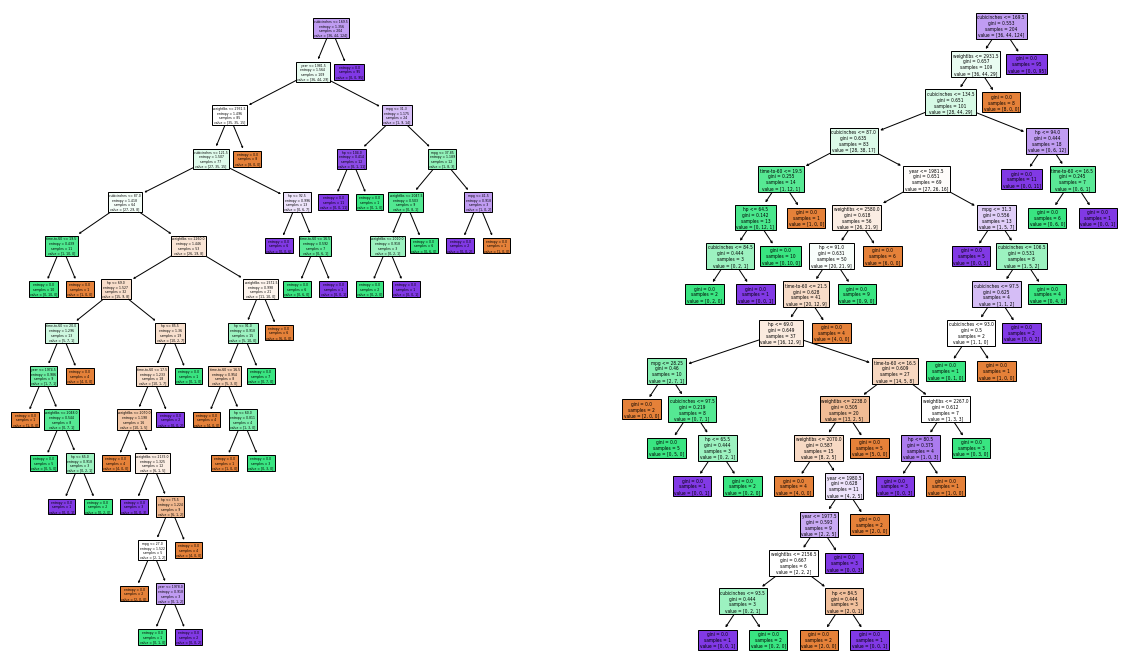

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figwidth(20)
fig.set_figheight(12)
tree.plot_tree(entropy_classifieur, ax=ax1, feature_names=fnames, filled=True)
tree.plot_tree(gini_classifieur, ax=ax2, feature_names=fnames, filled=True)
plt.show()

In [22]:
pd.DataFrame({
    "Criteres" : ["Temps Entrainement", "F1 Entrainement", "Temps Test", "F1 Test"],
    "Entropie" : entropy_stats,
    "Gini" : gini_stats
})

,Criteres,Entropie,Gini
0,Temps Entrainement,0.005039,0.004905
1,F1 Entrainement,1.000000,1.000000
2,Temps Test,0.000312,0.000806
3,F1 Test,0.826923,0.788462


#### II.1.2. Profondeur maximale de l'arbre

Pour chaque profondeur, on entraîne un modèle et on mesure sa convergence et sa performance en terme du score F1. 

**TODO : Analyser les résultats**
- Que remarquez-vous ? (Est-ce que plus de profondeur veut dire le modèle va généraliser mieux)
- Justifier

**Réponse**
- Remarque:
convergence d'entrainement :On remaque que F1 Score qui est égal a $$ F1 Score =  2PR /  P + R $$
  (et qui est la moyenne harmoniique entre la precision et le rappel ) de la convergence augmente avec l'augmentation de la profondeur de l'arbre , arrivé a un certain seuil qui est (entre 15 et 20 ) il se stabilise .

Pour le test on remarque que parfois ça augmente parfois ça  diminue :

[0,5] la convergence augmente 

[5,10] la convergence n'est pas stable  elle diminue (entre 5 et 6vapproximativvement), augmente (entre 6 et 7 ) puis se stabilise (entre  7 et 8 ) pour diminuer entre 8 et 10 

[10,12] la convergence augmente 

[12,13] se stabilise 

[13,15] diminue 

a partir de 15 F1 score se stabilise 

- Justification : 
F1 score augmente avec l'augmentation de la profondeur pour la convergence car la precision augmente on a plus de comparaison donc plus de précision  mais arrivé a un seuil l'arbre devient degénéré donc les performance atteint le max possible donc le f1 score ne va plus augmenter 
F1 Score n'est pas stable pour les tests car on a un probleme avec la generalisation c'est a dire vu qu'on a un seul arbre on tombe dans un cas de surapprentissage car le modéle a beaucoup appris surtout si la profondeur grandit donc les tests grandi ainsi le modéle apprend par coeur les données d'apprentissage il aura du mal a bien prédire dans le futur donc f1 score de tests ne va plus augmenter  d'autant plus que la recherche dans un arbre binaire est couteuse sachant que dans le pire des cas elle peut atteindre o(n) et ceci dégrade les performances

donc : non augmenter la profondeur ne veut pas dire que le modéle va mieux generaliser parceque d'aprés les résultats fourni augmentant la profondeur induit que le F1 score de test se tabilise 

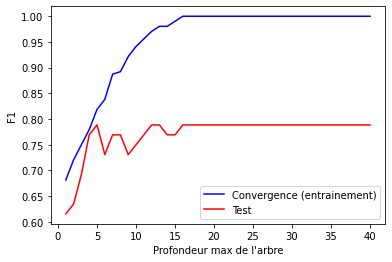

In [23]:
MAX_PROF = 40

MAX_PROF_lst = range(1, MAX_PROF+1, 1)

f1_train_pm = []
f1_test_pm = []
for max_prof in MAX_PROF_lst:
    classifieur = DecisionTreeClassifier(random_state=0, max_depth=max_prof)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_pm.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_pm.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MAX_PROF_lst, f1_train_pm, color="blue", label="Convergence (entrainement)")
plt.plot(MAX_PROF_lst, f1_test_pm, color="red", label="Test")
plt.ylabel("F1")
plt.xlabel("Profondeur max de l'arbre")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

#### II.1.3. Observations minimales dans les feuilles

Pour chaque nombre des observations minimales dans les feuilles, on entraîne un modèle et on mesure sa convergence et sa performance en terme du score F1. 

**TODO : Analyser les résultats**
- Que remarquez-vous ?
- Justifier pourquoi la performance se diminue (en indiquant si ce critère d'arrêt garantie un apprentissage normale ou peut causer un sur-apprentissage ou sous-apprentissage)

**Réponse**
- Remarque:

Convergence:On remarque que F1 score diminue pour la  convergence d'entrainement en augmentant le nombre de feuilles , mais se stabilise antre [15,25] 

Tests : On remarque que pour les tests F1 score n'est pas stable (entre augmentaton et diminution (oscillation) ) :

[0,5 ] : F1 score augmente

[5,6] : stabilité

[6,7] : diminution

[7,8]: augmentation 

[8,9]: diminution 

[9,10] : stabilité

[10,11]: augmentation

[11,15]:diminution 

[15,25]: stabilité

[25,27]augmentation

[27,28] stabilité 

[28,30] dimminution

[30,35] stabilité

[35,40] augmentation


    - La performance diminue lorsque on  a un grand nombre de feuilles car on a plus de régle donc on rencontre un problème de surapprendtissage le modéle a beaucoup appris sur les memes données au point ou il n'arrive pas a généraliser , et lorsqu'on a un petit nombre de feuille le modéle n'a pas assez appris aussi on a un problème de sous apprentissage , ce qui veut dire que le nombre idéale c'est d'avoir entre [15,25] , moins on a un problème de sous apprentissage et plus on a un problème de sur apprentissage 

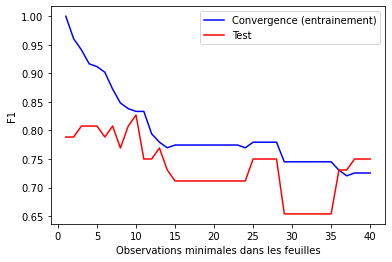

In [24]:
MIN_FEUILLE = 40

MIN_FEUILLE_lst = range(1, MIN_FEUILLE+1, 1)

f1_train_mf = []
f1_test_mf = []
for min_feuille in MIN_FEUILLE_lst:
    classifieur = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_feuille)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_mf.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_mf.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MIN_FEUILLE_lst, f1_train_mf, color="blue", label="Convergence (entrainement)")
plt.plot(MIN_FEUILLE_lst, f1_test_mf, color="red", label="Test")
plt.ylabel("F1")
plt.xlabel("Observations minimales dans les feuilles")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

### II.2. Forêts aléatoires

#### II.2.1. Nombre des arbres

Pour chaque nombre des arbres dans le forêt, on entraîne un modèle et on mesure sa convergence et sa performance en terme du score F1. 

**TODO : Analyser les résultats**
- Que remarquez-vous ? (convergence et généralisation)

**Réponse**
- On remarque que F1 score de la convergence  diminue au départ lorsqu'on a pas assez d'arbre donc problème avec la généralisation mais il  augmente puis se stabilise au bout de 20 arbres c'est a dire qu'il a atteint le maximum est que augmenter le nombre d'arbres ne va pas amener des informations en plus qui vont ameliorer la performance,  ce nombre d'arbres peut etre considéré comme un critére d'arret

F1 score de la convergence est meileur  que celui des tests 

- par contre F1 score de tests on a des oscillations donc il  n'est pas satable augmente et diminue avec l'augmentation du nombre d'arbre et cela est du au faite que lorsqu'on a un nombre d'arbres pas suffisant le modéle a du mal a generaliser donc on a problème de surapprentissage surtout lorsque on prend tous les attributs , dont certains d'entre eux peuvent etre sur-dominant donc attient la performance vers eux ce qui flisifiera les resultas  , mais lorsque le nombre est asssez grand aussi on a un problème avec les performances car la recherche dans un arbre prend beuacoup de temps complexite o(n) dans le pire des cas et ça dans un seul arabre donc dans une foret avec plusieurs arbres ça prendre plus de temps de tests c'est pour ça qu'on a pas un stabilité , donc ça serai bien d'avoir un nombre d'arbre raisonnable , et procéder a la selection d'attribut afin de laisser que ceux qui représente au mieux l'informations c'esta dire ce qui ne sont pas dominant .


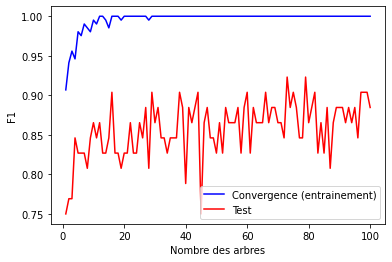

In [25]:
from sklearn.ensemble import RandomForestClassifier

MAX_ARBRE = 100

MAX_ARBRE_lst = range(1, MAX_ARBRE+1, 1)

f1_train_nbarbres = []
f1_test_nbarbres = []
for max_arbres in MAX_ARBRE_lst:
    classifieur = RandomForestClassifier(n_estimators=max_arbres)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_nbarbres.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_nbarbres.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MAX_ARBRE_lst, f1_train_nbarbres, color="blue", label="Convergence (entrainement)")
plt.plot(MAX_ARBRE_lst, f1_test_nbarbres, color="red", label="Test")
plt.ylabel("F1")
plt.xlabel("Nombre des arbres")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

#### II.2.2. Profondeur maximale des arbres

Pour chaque profondeur, on entraîne un forêt et on mesure sa convergence et sa performance en terme du score F1. On compare les résultats avec les arbres équivalents (avec la même profondeur)

**TODO : Analyser les résultats**
- Comparer la convergence des forêts et des arbres en terme de la profondeur maximale
- Comparer la généralisation des forêts et des arbres en terme de la profondeur maximale
- Justifier ces résultats (en indiquant pourquoi nous avons des oscillations dans F1 test des forêts)

**Réponse**
- La convergence des forets et des arbres augmentent avec l'augmentation de la profondeur des arbres mais arrivé a une certaine profondeure 15 cette convergence se stabilise ce qui veut dire que elle a atteint la profondeur max , si on augmente la profondeur les arbres commencent a etre degenerer et la recherche dans un arbre degenerer est tres couteuse 
- pour la généralisation des forets on remarque qu'il y'a des oscillations ce n'est pas stable le f1 score augmente puis diminue par contre pour les arbres avant la profondeur 15 on détécte de légéres oscilliations puis f1 score  se stabilise 

la performance de la convergence , et des tests  des foretes est meilleure que la performance et tests de la convergence des arbres .
- Justification : 

la convergence des arbres augmente jusqu'a une profondeure max = 15 par ce que , avant la profondeur 15 les informations sont bien représentée on a suffisement de comparaision afin d'apprendre et genéraliser , et la recherche dans ce cas ne va pas etre trés couteuse , dépasser la profondeur 15 , les compraisons ne donnt pas des informations complementaire necessaires a l'apprentissage (c'est comme si qu'il y'aura une redonance ) donc ça ne sert a rien de dépasser cette profondeur car elle peut représenté un critére d'arret pour le modele des arbres de decisions 

La performance de la convergence des foretes suit la meme evolution que celle des arbres mais elle est mailleure car ici on a beaucoup d'arbres donc le modéle va généraliser mieux car il a beaucoup de cas traité , avant la profondeur 15 mais lorsque la profondeur dépasse la profondeur max donc les arbres vont etre degenrées donc performances dégradées.

La performance des tests des arbres avant la profondeur 15 sont instables car le problème de generation a cause du surapprentissage du modéle qui a trop bien appris par coeur tous les comparaisons ett cas de la convergence , ceci empeche de mieux prédire , apres la profondeur 15 les comparaisons n'apportent pas unen information complementaire c'est comme un critére d'arrte meme l'apprentissage se stabilise a ce niveau .

La performance des tests de forets  sont des oscilliations car on a un probleme de sur apprentissage surtout en augmentant la profondeur associée au probleme de degenrence de l'arbre lorsque la profondeur devient trés grande la recherche  devient trés couteuse déja dans un seul arbre , et dans une forets elle est parfois polynmiale elle s'effectue avec le vote majoraitaire  surtout qu'on a pas appliqué un mécanisme de séléction d'attributs tel que la méthode filtre par exemple .

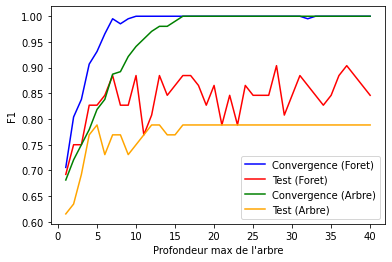

In [26]:
f1_train_pm_foret = []
f1_test_pm_foret = []
for max_prof in MAX_PROF_lst:
    classifieur = RandomForestClassifier(n_estimators=40, max_depth=max_prof)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_pm_foret.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_pm_foret.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MAX_PROF_lst, f1_train_pm_foret, color="blue", label="Convergence (Foret)")
plt.plot(MAX_PROF_lst, f1_test_pm_foret, color="red", label="Test (Foret)")
plt.plot(MAX_PROF_lst, f1_train_pm, color="green", label="Convergence (Arbre)")
plt.plot(MAX_PROF_lst, f1_test_pm, color="orange", label="Test (Arbre)")
plt.ylabel("F1")
plt.xlabel("Profondeur max de l'arbre")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

#### II.2.3. Observations minimales dans les feuilles

Pour chaque nombre minimale des observations dans les feuilles, on entraîne un forêt et on mesure sa convergence et sa performance en terme du score F1. On compare les résultats avec les arbres équivalents (avec le même nombre des observations minimales)

**TODO : Analyser les résultats**
- Comparer la performance (convergence et généralisation) des arbres et des forêts en terme du noombre des observations dans les feuilles
- Justifier 

**Réponse**
- La performance (f1 score ) de convergence et de généralisation diminue en augmentant les observations minimales dans les feuilles pour les arbres et pour les forets , malgré qu'on remarque une certaines stabilité de la convergence des arbres et des forets lorsque le nombre de feuille est entre [15,25] [30,35]

- Lorsque le nombre de feuile est inférieure a 15 le modéle n'apprend pas bien quelque soit pour les arbres ou bien pour les forets car on a pas assez de regles qui permettent de bien apprendre donc on a  un souci de sous apprentissage donc mauvaise generalisation , entre [15,25] [30,35] c'est le nombre de feuilles idéales un arbre apprend bien donc les foretes aussi apprenent bien c'est pour ça on a une stabilité de la performance de convergence  par contre la performance des tests se dégrade en augmentant le nombre des feuiles car la recherche devient de plus en plus couteuse surtout lorsque le nombre de feuilles est trés grand 

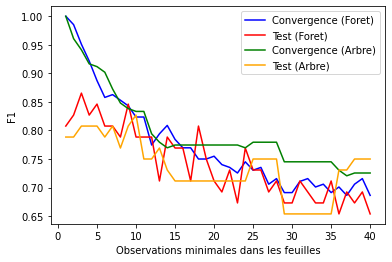

In [27]:
f1_train_mf_foret = []
f1_test_mf_foret = []
for min_feuille in MIN_FEUILLE_lst:
    classifieur = RandomForestClassifier(n_estimators=40, min_samples_leaf=min_feuille)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_mf_foret.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_mf_foret.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(MIN_FEUILLE_lst, f1_train_mf_foret, color="blue", label="Convergence (Foret)")
plt.plot(MIN_FEUILLE_lst, f1_test_mf_foret, color="red", label="Test (Foret)")
plt.plot(MIN_FEUILLE_lst, f1_train_mf, color="green", label="Convergence (Arbre)")
plt.plot(MIN_FEUILLE_lst, f1_test_mf, color="orange", label="Test (Arbre)")
plt.ylabel("F1")
plt.xlabel("Observations minimales dans les feuilles")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()

#### II.2.4. Taille d'un Bootstrap

Ici, on définit un pourcentage de la taille des Bootstrap par rapport la taille initiale du dataset. Pour chaque pourcentage, on entraîne un forêt et on test sa performance (convergence et généralisation) en utilisant la mesure F1.

**TODO : Analyser les résultats**
- Que remarquez-vous ?
- Quelle est la raison pour laquelle la performance n'augmente pas d'une manière lisse ?

**Réponse**
- On remarque que la performance de convergence ou de tests  prend la forme d'osciliation qui augmente  tout en augmentant le pourcentage du bootstrap , la convergence des foretes aura tendance a tendre vers 1 
- La performance n'augmente pas de maniére lisse car on divise les bootstrap aleatoirment ce qui rend les forets non deterministes , donc la performance ne peut pas augmenter de maniére linéaire en plus on n'a pas appliqué une selection d'attributs ici donc meme si on augmente le pourcentage du bootsrap certains attributs attirent l'attention que dautre donc ce qui prvoque l'instabilité , donc la quantité n'est pas le plus impotant

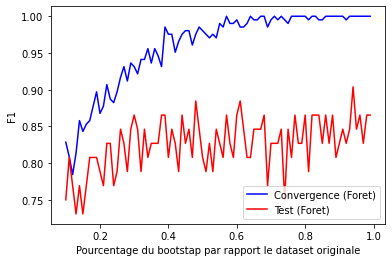

In [28]:
POUR_OBS_lst = np.arange(0.1, 1, 0.01)

f1_train_ech = []
f1_test_ech = []
for pour_obs in POUR_OBS_lst:
    classifieur = RandomForestClassifier(n_estimators=40, max_samples=pour_obs)
    classifieur.fit(X_cars_train, Y_cars_train)
    f1_train_ech.append(f1_score(Y_cars_train, classifieur.predict(X_cars_train), average="micro"))
    f1_test_ech.append(f1_score(Y_cars_test, classifieur.predict(X_cars_test), average="micro"))

plt.plot(POUR_OBS_lst, f1_train_ech, color="blue", label="Convergence (Foret)")
plt.plot(POUR_OBS_lst, f1_test_ech, color="red", label="Test (Foret)")
plt.ylabel("F1")
plt.xlabel("Pourcentage du bootstap par rapport le dataset originale")
plt.legend()
#plt.rcParams["figure.figsize"] = (3,7)
plt.show()